In [22]:
from __future__ import annotations

import requests
import os
import json
from multiprocessing import Pool
from concurrent.futures import ThreadPoolExecutor

from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from matplotlib import pyplot as plt
import faiss
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [23]:
data_path = '/Users/jsb/repos/moodboard/gist_app/data/asos/all_products.json'

In [24]:
import json

with open(data_path, 'r') as fp:
    products = json.loads(fp.readline())

In [25]:
products[0]

{'id': 200604040,
 'name': 'Mango short sleeve maxi dress in black',
 'price': {'current': {'value': 29.0, 'text': '$29.00'},
  'previous': {'value': None, 'text': ''},
  'rrp': {'value': 48.0, 'text': '$48.00'},
  'isMarkedDown': False,
  'isOutletPrice': True,
  'currency': 'USD'},
 'colour': 'Black',
 'colourWayId': 200604041,
 'brandName': 'Mango',
 'hasVariantColours': False,
 'hasMultiplePrices': False,
 'groupId': None,
 'productCode': 105018995,
 'productType': 'Product',
 'url': 'mango/mango-short-sleeve-maxi-dress-in-black/prd/200604040?clr=black&colourWayId=200604041',
 'imageUrl': 'images.asos-media.com/products/mango-short-sleeve-maxi-dress-in-black/200604040-1-black',
 'additionalImageUrls': ['images.asos-media.com/products/mango-short-sleeve-maxi-dress-in-black/200604040-2',
  'images.asos-media.com/products/mango-short-sleeve-maxi-dress-in-black/200604040-3',
  'images.asos-media.com/products/mango-short-sleeve-maxi-dress-in-black/200604040-4'],
 'videoUrl': 'video.asos

In [26]:
# tweaked from https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPModel.forward.returns

# below is standard CLIP usage to score text snippets against a photo

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [27]:
def images_to_embeddings(images: list[Image]) -> torch.tensor:
    """"""
    vinput = processor(images=images, return_tensors="pt")

    voutput = model.vision_model(
        **vinput
    )

    vembeds = voutput[1]

    vembeds = model.visual_projection(vembeds)

    vembeds = vembeds / vembeds.norm(p=2, dim=-1, keepdim=True)
    
    return vembeds

# build amazon dataset

download dataset from https://data.world/promptcloud/amazon-fashion-products-2020/file/marketing_sample_for_amazon_com-amazon_fashion_products__20200201_20200430__30k_data.ldjson

In [44]:
type(products[1]["id"])

int

In [98]:
class AsosClothingDataset(Dataset):
    """
    dataset found at https://data.world/promptcloud/amazon-fashion-products-2020/file/marketing_sample_for_amazon_com-amazon_fashion_products__20200201_20200430__30k_data.ldjson
    downloads dataset images fast with multithreading, and includes 
    category-specific subsetting for fast recommendation over a category
    """
    @staticmethod
    def read_records(fpath):
        records = []
        with open(fpath, 'r') as fp:
            for line in fp:
                records.append(json.loads(line))
        return records
    
    def _download(self, record):
        """download a single record"""
        md = None
        try:
            image_url = "https://" + record["imageUrl"]
#             print(image_url)
            print(record["id"])
#             os.makedirs(image_dir, exist_ok=True)
            image_path = os.path.join(self.image_dir, str(record["id"]) + ".jpg")
#             print(image_path)
            if not os.path.exists(image_path):
                image = Image.open(requests.get(image_url, stream=True).raw)
#                 print(image)
                image.save(image_path)
#                 print(image)

            label = f"a catalog photo of {record['name']}"
            
#             print(label)
            
            category = "dress"

            md = {
                "product_id": record["id"],
                "image_path": image_path,
                "image_url": image_url,
                "label": label,
                "category": category,
            }
        except:
            print('failed')
            md = None

        return md

    @staticmethod
    def _thread_run(f, my_iter):
        """download all records using multithreading"""
        with ThreadPoolExecutor() as executor:
            results = list(tqdm(executor.map(f, my_iter), total=len(my_iter)))
        return results


    def __init__(self, image_dir: str, records: List[dict]):
        
        ids = [rec["id"] for rec in records]
        
        self.image_dir = image_dir
        
        os.makedirs(self.image_dir, exist_ok=True)
        
        # download images and return metadata
#         mds = []
#         for record in records:
#             md = self._download(record)
#             mds.append(md)
        
        mds = self._thread_run(self._download, records)
        mds = [md for md in mds if md is not None]
    
        self.metadata = pd.DataFrame(mds)
        self.metadata.set_index("product_id")
        self.metadata.sort_index()
        self.metadata.reset_index(drop=True)
        
    def __getitem__(self, idx: int) -> (Image, str, str):
        md = self.metadata.iloc[idx]
        
        try:
            image = Image.open(md.image_path)
        except:
            image = None

        return (image, md.label, md.category)
    
    def __len__(self,) -> int:
        return len(self.metadata)
    
    
    def get_category_indices(self, category: str) -> np.array:
        """return the indices of all products in this category"""
        md = self.metadata[self.metadata.category == category]
        return md.index

In [103]:
image_dir = "./TEST"

records = products[:120]

asos_dataset = AsosClothingDataset(image_dir=image_dir, records=records)

200604040
203527789
203897636
203897814
203899196
204097500
204483720
204669445
204692023
204740491
204877582
204877590
204877907
203897757
203897893
203447452
203987907
204945235
203853971
204688035
204688094
204688095
204688221
204688224
204740416
204868981
202844832
202998977
204624632
204939544
202641270
202677053
203353495
203720726
203725676
203897692
203897725
203897821
203897892
203899062
203899180
204097124
204107133
204190029
204247029
204267636
204316219
204344925
204347966
204349391
204420041
204472307
204473636
204478687


 39%|████████████████████████████████████                                                        | 47/120 [00:00<00:01, 52.67it/s]

204496850204497935

204512946
204536690
204557919
204565298
204565598
204624683
204636021
204660253
204676272
204681395
204682083
204688043


 46%|██████████████████████████████████████████▏                                                 | 55/120 [00:01<00:01, 38.60it/s]

204688142
204688150
204688174
204691951
204692039
204704761
204739353


 49%|█████████████████████████████████████████████▏                                              | 59/120 [00:01<00:01, 32.57it/s]

204740438
204760709
204781706
204783414
204784862
204804379


 57%|████████████████████████████████████████████████████▉                                       | 69/120 [00:01<00:01, 29.06it/s]

204817581
204823232
204823478
204823480
204866213
204866262
204866278
204866294


 68%|██████████████████████████████████████████████████████████████▊                             | 82/120 [00:02<00:01, 30.41it/s]

204877598204877606

204886323
204938377
204945879
205143685
205148931
205149001
205168266


 75%|█████████████████████████████████████████████████████████████████████                       | 90/120 [00:02<00:01, 27.03it/s]

203723915
203897660
203989466
204097830
204165598
204237057
204237066
204237074
204237082


 78%|████████████████████████████████████████████████████████████████████████                    | 94/120 [00:02<00:00, 29.24it/s]

204237090
204237130
204237138
204241115
204344812


 82%|███████████████████████████████████████████████████████████████████████████▉                | 99/120 [00:02<00:00, 27.53it/s]

204374577
204409784


 85%|█████████████████████████████████████████████████████████████████████████████▎             | 102/120 [00:03<00:00, 20.68it/s]

204428317204496934

204514541
204514557
204514558
204514589


100%|███████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.26it/s]


In [104]:
ls TEST

200604040.jpg  203987907.jpg  204409784.jpg  204676272.jpg  204804379.jpg
202641270.jpg  203989466.jpg  204420041.jpg  204681395.jpg  204817581.jpg
202677053.jpg  204097124.jpg  204428317.jpg  204682083.jpg  204823232.jpg
202844832.jpg  204097500.jpg  204472307.jpg  204688035.jpg  204823478.jpg
202998977.jpg  204097830.jpg  204473636.jpg  204688043.jpg  204823480.jpg
203353495.jpg  204107133.jpg  204478687.jpg  204688094.jpg  204866213.jpg
203447452.jpg  204165598.jpg  204483720.jpg  204688095.jpg  204866262.jpg
203527789.jpg  204190029.jpg  204496850.jpg  204688142.jpg  204866278.jpg
203720726.jpg  204237057.jpg  204496934.jpg  204688150.jpg  204866294.jpg
203723915.jpg  204237066.jpg  204497935.jpg  204688174.jpg  204868981.jpg
203725676.jpg  204237074.jpg  204512946.jpg  204688221.jpg  204877582.jpg
203853971.jpg  204237082.jpg  204514541.jpg  204688224.jpg  204877590.jpg
203897636.jpg  204237090.jpg  204514557.jpg  204691951.jpg  204877598.jpg
203897660.jpg  204237130.jpg  20451455

In [105]:
asos_dataset.metadata

,product_id,image_path,image_url,label,category
0,200604040,./TEST/200604040.jpg,https://images.asos-media.com/products/mango-s...,a catalog photo of Mango short sleeve maxi dre...,dress
1,203527789,./TEST/203527789.jpg,https://images.asos-media.com/products/vesper-...,a catalog photo of Vesper square neck thigh sp...,dress
2,203897636,./TEST/203897636.jpg,https://images.asos-media.com/products/naanaa-...,a catalog photo of NaaNaa sequin mini dress wi...,dress
3,203897814,./TEST/203897814.jpg,https://images.asos-media.com/products/naanaa-...,a catalog photo of NaaNaa sequin long sleeve d...,dress
4,203899196,./TEST/203899196.jpg,https://images.asos-media.com/products/naanaa-...,a catalog photo of NaaNaa cowl neck satin maxi...,dress
...,...,...,...,...,...
115,204496934,./TEST/204496934.jpg,https://images.asos-media.com/products/neon-ro...,a catalog photo of Neon Rose Plus gingham mida...,dress
116,204514541,./TEST/204514541.jpg,https://images.asos-media.com/products/never-f...,a catalog photo of Never Fully Dressed wrap ti...,dress
117,204514557,./TEST/204514557.jpg,https://images.asos-media.com/products/never-f...,a catalog photo of Never Fully Dressed contras...,dress
118,204514558,./TEST/204514558.jpg,https://images.asos-media.com/products/never-f...,a catalog photo of Never Fully Dressed satin w...,dress


# pre-calculate embeddings for all dataset products

In [107]:
def collate_fn(batch):
    images, labels, categories = [], [], []
    for item in batch:
        image, label, category = item
        # filter out any datapoints with corrupt images
        if image is not None:
            images.append(image)
            labels.append(label)
            categories.append(category)
    return images, labels, categories


data_loader = DataLoader(
    dataset = asos_dataset,
    collate_fn = collate_fn,
    batch_size = 32,
    shuffle = False,
)

In [40]:
os.remove(embeddings_path)

In [108]:
embeddings_path = os.path.join(image_dir, 'asos_embeddings.npy')

if not os.path.exists(embeddings_path):
    candidate_vembeds = []

    count = 0
    for imgs, labs, cats in tqdm(data_loader):
        count += len(imgs)
        with torch.no_grad():
            candidate_vembeds.append(images_to_embeddings(imgs))

    candidate_vembeds = torch.concat(candidate_vembeds)
    candidate_vembeds = candidate_vembeds.detach().numpy()
    np.save(embeddings_path, candidate_vembeds)

candidate_vembeds = np.load(embeddings_path)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]


# search over a category in the dataset

In [135]:
category_vembeds = candidate_vembeds
dim = category_vembeds.shape[1]
index = faiss.IndexFlatIP(dim)
index.add(category_vembeds)


def search(w1, image_url1, image_url2, index, k=10):
    image1 = Image.open(requests.get(image_url1, stream=True).raw)
    image2 = Image.open(requests.get(image_url2, stream=True).raw)
    
    with torch.no_grad():
        query_vembeds = images_to_embeddings([image1, image2])

    new_query = (w1 * query_vembeds[0]) + ((1. - w1) * query_vembeds[1]).unsqueeze(0)
    new_query = new_query / new_query.norm(p=2, dim=-1, keepdim=True)

    new_query = new_query.detach().numpy()
    dists, idxs = index.search(new_query, k)

    return dists, idxs

In [136]:
dists, idxs = search(0.5, image_url1, image_url2, index, k=10)

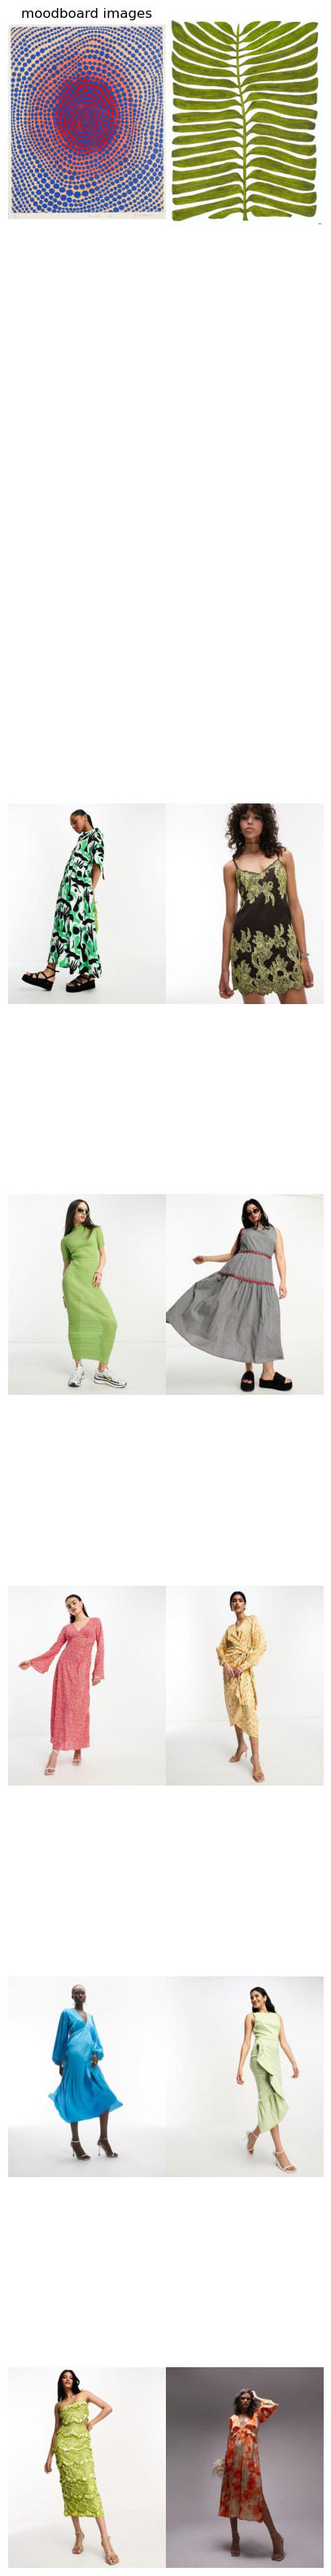

In [151]:
category_vembeds = candidate_vembeds
dim = category_vembeds.shape[1]
index = faiss.IndexFlatIP(dim)
index.add(category_vembeds)

# get our query embeddings
image_url1 = "https://i.pinimg.com/474x/53/37/d5/5337d5464816d2c405b80cb7283edaa9.jpg"
image_url2 = "https://i.pinimg.com/474x/65/76/5d/65765da55a1c7043d13908e098d62814.jpg"

# image_url = "https://i.pinimg.com/564x/2a/da/f7/2adaf77f93508acd3e2d3448768be26b.jpg"
# image_url = "https://i.pinimg.com/564x/6f/38/29/6f38294fdc3f59e20be41c7e66f0bcaf.jpg"
# image_url = "https://i.pinimg.com/564x/25/2c/5c/252c5cb1b521c13a97045bc73add3751.jpg"
# image_url = "https://i.pinimg.com/564x/f9/9c/77/f99c77136c9b0af5eab79bfcbd414aed.jpg"
# image_url = "https://i.pinimg.com/564x/99/8c/14/998c14a26d8bedcf39c63265d332fa75.jpg"
k = 10

dists, idxs = search(0.5, image_url1, image_url2, index=index, k=k)

# plot
image1 = Image.open(requests.get(image_url1, stream=True).raw)
image2 = Image.open(requests.get(image_url2, stream=True).raw)

fig, axes = plt.subplots(1 + (k // 2), 2, 
                         figsize = (5, 50), 
                         gridspec_kw={'height_ratios': [3] + [1] * (k//2),})

for ax in axes.ravel():
    ax.axis("off")
    
axes[0, 0].imshow(image1)
axes[0, 1].imshow(image2)
axes[0, 0].set_title("moodboard images")

i, j = 1, 0
for idx in idxs[0]:
    ax = axes[i, j]
    ax.imshow(asos_dataset[idx][0])
    ax.set_aspect("equal")
    j += 1
    if j == 2:
        j = 0
        i += 1

plt.subplots_adjust(hspace=0.0, wspace = 0.0)
plt.show()